# Multi Layer Perceptron based language model
* based on https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open('names.txt','r').read().split('\n')
words[:10],len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [3]:
chars = sorted(list(set(''.join(words))))
S_I = {c:i+1 for i,c in enumerate(chars)}
S_I['.'] = 0
I_S = {i:c for c,i in S_I.items()}
print(I_S)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [18]:
block_size = 3  # context size
def build_dataset(words):
    # build the dataset
    

    X,Y = [],[] # input, labels
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = S_I[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join([I_S[i] for i in context]),'->',I_S[ix])
            context = context[1:] + [ix]

    X = torch.Tensor(X).int()
    Y = torch.Tensor(Y).int()
    print(X.shape,Y.shape)
    return X,Y

# split into train val and test
random.seed(42)
random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train,Y_train = build_dataset(words[:n1])  #train network
X_val,Y_val = build_dataset(words[n1:n2])    # tune hyperparameters
X_test,Y_test = build_dataset(words[n2:])    # final evaluation

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


* https://www.tensorflow.org/text/tutorials/warmstart_embedding_matrix

* https://pytorch.org/docs/stable/generated/torch.cat.html         to concat dim 1,2
* https://pytorch.org/docs/stable/generated/torch.unbind.html      drop dim into tuple
* https://pytorch.org/docs/stable/generated/torch.Tensor.view.html  efficient way
* tensors are stored as one dimensional (Tensor.storage) 
* http://blog.ezyang.com/2019/05/pytorch-internals/

In [5]:
#torch.cat(torch.unbind(emb,1),dim=1).shape  # correct shape for matrix multiplication but not efficient

In [6]:
# Layers
g = torch.Generator().manual_seed(2147483647)

# lookup table
C = torch.randn((len(S_I),10),generator=g) # weights

W1_neurons =200
W1 = torch.randn((30,W1_neurons),generator=g) # weights for the hidden/tanh layer
B1 = torch.randn((1,W1_neurons),generator=g) #bias
# in current state it is not possible to use matrix multiplication as [32,3,2] @ [6,100] is not possible

W2 = torch.randn((W1_neurons,len(S_I)),generator=g) # weights for the output layer
B2 = torch.randn((len(S_I)),generator=g) # bias

params = [C,W1,B1,W2,B2]


In [7]:
sum([p.nelement() for p in params])

11897

In [8]:
for p in params:
    p.requires_grad_(True)

In [9]:
# from bruteforce we can say best learning rate should be between 0.001 to 1
exp_Lr = torch.linspace(3,0,30000) # 10^-3 to 10^0
Lr = torch.pow(10,exp_Lr)

In [10]:
BATCH_SIZE = 64
lri=[]
lossi=[]
stepi=[]

In [11]:


for i in range(200000):
    # create minibatch
    ix = torch.randint(0,len(X_train),(BATCH_SIZE,))  # 32 random numbers between 0 and len(X) size needs to be tupple
    
    # forward pass
    emb = C[X_train[ix]] # embedding layer / input to tanh layer (mini batch of 32 items) #           loosely  a representaion of words
    h = torch.tanh(emb.view(-1,30) @ W1 + B1) # hidden states view(-1,6) automatically infers the dim / can also be done as view(emb.shape[0],6)
    # h,h.shape # b1 is broadcasted to correct shape here

    logits = h @ W2 + B2
    # counts = logits.exp()
    # probs = counts / counts.sum(1,keepdims=True)
    # loss = -(probs[torch.arange(32),Y]).log().mean() 
    loss = F.cross_entropy(logits,Y_train[ix].long()) # same but more efficient as above one creates a lot of intermediate tensors  # exp(large number) = inf so it is numerically unstable
    # simpler to implement backpropagation
    # cross entropy subtracts the largest number from the logits to avoid overflow in exp    
    #print(loss.item())
    # backward pass
    for p in params:
        p.grad = None
    loss.backward(retain_graph=True)
   
    # update the parameters
   # lr = Lr[i] # try different learning rates
    lr = 0.1 if i<100000 else 0.01
    for p in params:
        p.data -= p.grad * lr
        
    #track
    # lri.append(exp_Lr[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    
print(loss.item())  # loss for a single batch

2.1650948524475098


In [12]:
emb = C[X_val] # embedding layer / input to tanh layer (mini batch of 32 items) #           loosely  a representaion of words
h = torch.tanh(emb.view(-1,30) @ W1 + B1) # hidden states view(-1,6) automatically infers the dim / can also be done as view(emb.shape[0],6)
logits = h @ W2 + B2
loss = F.cross_entropy(logits,Y_val.long())
loss

tensor(2.1592, grad_fn=<NllLossBackward0>)

In [13]:
emb = C[X_test] # embedding layer / input to tanh layer (mini batch of 32 items) #           loosely  a representaion of words
h = torch.tanh(emb.view(-1,30) @ W1 + B1) # hidden states view(-1,6) automatically infers the dim / can also be done as view(emb.shape[0],6)
logits = h @ W2 + B2
loss = F.cross_entropy(logits,Y_test.long())
loss

tensor(2.1579, grad_fn=<NllLossBackward0>)

Text(0, 0.5, 'loss')

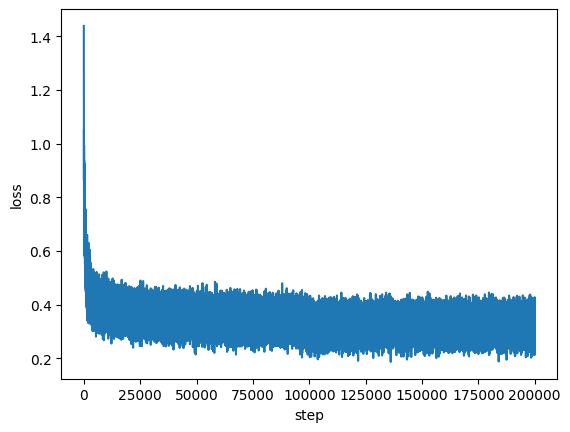

In [14]:
plt.plot(stepi,lossi)
plt.xlabel('step')
plt.ylabel('loss')
# noise in the loss is due to the random minibatch or small batch size

# this network has relatively low number of parameters,
# for a larger network, it is earier to overfit,
### split data in 3

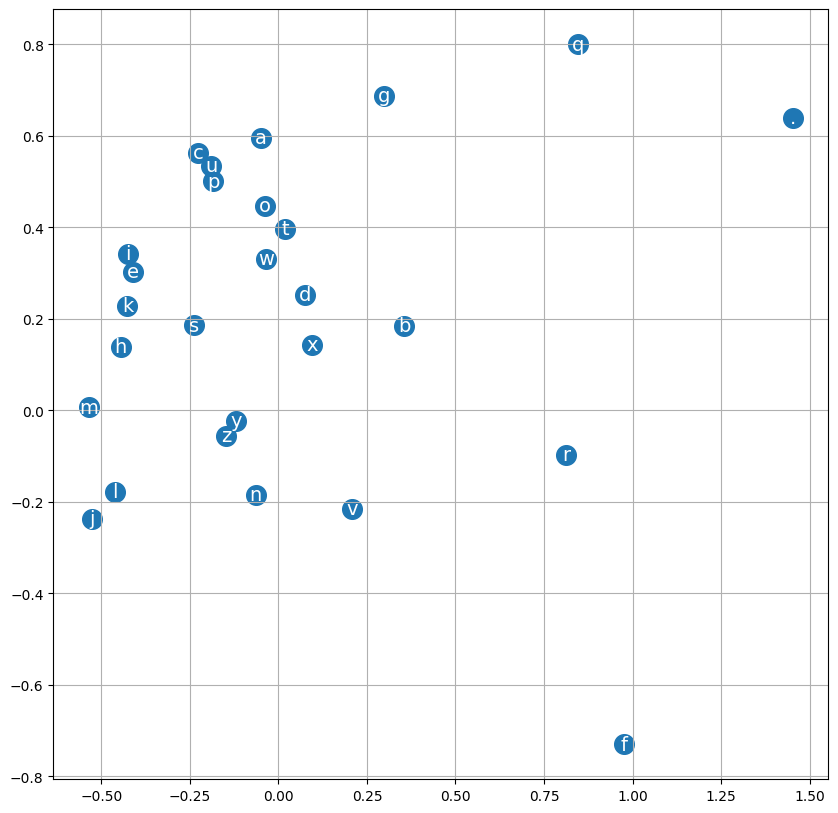

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data,C[:,1].data,s=200)  
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),I_S[i],ha='center',va='center',color='white',fontsize=14)
plt.grid('minor')

In [16]:
# the embeddings show that the model has learned some structure 

In [19]:
# sampling
G = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + B1)
        logits = h @ W2 + B2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=G).item()
        context = context[1:] + [ix]
        out.append(I_S[ix])
        if I_S[ix] == '.':
            break 
    print(''.join(out))

mora.
mayah.
seel.
nihah.
marethrstengrace.
adelyn.
eliah.
milopaleigh.
estanaraelyn.
malaia.
nyshabergiaganest.
jairendy.
panthuor.
usman.
dariyah.
faeha.
kayshaston.
mahia.
sakylisus.
zakhlee.
